# Aim:

- This notebook will made a deterministic model of the SEI5R for South Africa and the provinces using PyRoss
- This model does not assume any lockdow scenarios and uses the current value to predict the trajectory of the epidemy


In [34]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  


Nothing done.


In [35]:
ForColab = False


## NB: The Pyross is not working in Colab, I will use Github as a platform to share and make amendments to the code


In [36]:
#
# This is here but not working fully in Colab
#
if ForColab:
    !pip install wget
    !pip install git+https://github.com/rajeshrinet/pyross.git
    !pip install git+https://github.com/lukastk/PyRossGeo.git
    import os
    owd = os.getcwd()
    os.chdir('../../')

    import plotly.io as pio
    pio.renderers.default = 'colab'
else:
    print("Working local")

Working local


In [37]:
#
# Import the parameters for the plots
#
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
         'figure.max_open_warning': 0}
         
plt.rcParams.update(params)

#import matplotlib
#matplotlib.use("cairo")
#import cairo 3 might not need this in the end

In [38]:
from datetime import datetime, timedelta, date

import os
from pathlib import Path
import pickle
from timeit import default_timer as timer
#
# The following is needed for pulling the files from Github
#
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
    
import pandas as pd
#pd.options.plotting.backend = "plotly"

import numpy as np
from numba import jit

from tqdm.notebook import tqdm

from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize,curve_fit

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from PIL import Image

#import chart_studio
#chart_studio.tools.set_config_file(world_readable=False)

#import chart_studio.plotly as ply

#
# Import pyross and pyrossgeo
#

import pyross, pyrossgeo

In [39]:
def plot_model(Data,  ICUHospital, title):

    S  = model.S(Data)
    Ia = model.Ia(Data)
    Is = model.Is(Data)
    R  = model.R(Data)

    InfectedCases = Ia+Is

    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    fig, ax1 = plt.subplots(1, 1)
    fig.suptitle(title)

    ax1.plot(S, 'tab:blue', label='Susceptible');
    ax1.plot(Ia, 'tab:orange', label='Exposed');
    ax1.plot(Is, 'tab:red', label='Infected');
    ax1.plot(R, 'tab:green', label='Recovered');
    #ax1.plot(InfectedCases, 'tab:purple', label='Hospitalised');
    #ax1.plot(crit, 'tab:brown', label='Critical');
    #ax1.plot(death, 'tab:cyan', label='Deceased');
    #ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
    #           label="Mean ICU beds")


    ax1.semilogy()

    ax1.set_xlabel("Days");
    ax1.legend(loc='best');
    ax1.set_ylabel("No of people");
    '''        
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.semilogy()

    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.semilogy()
    '''

    '''
    ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
    ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
    '''        

    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)


# Setting the total poplation for South Africa


In [40]:

NZA = 59156682     # Total number of people in SA


# Getting Covid values for cases in SA for each province 

In [41]:
def get_SA_province(ToUpdateSAProvince):
    
    '''
    This function will get the SA provincial confirmed and cases as function of date from the Uni Pretoria repo
    
    It also has the total that should agree with the reported worldodometer confirmed cases
    
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province confirmed dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
        SAProvinConfirmed = pd.read_csv(wget.download(ConfirmedURL, out ='covid19za_provincial_cumulative_timeline_confirmed.csv'))
        
        DeathURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"
        SAProvinDead = pd.read_csv(wget.download(DeathURL, out= 'covid19za_provincial_cumulative_timeline_deaths.csv'))
        
        RecoveredURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
        SAProvinRecover = pd.read_csv(wget.download(RecoveredURL, out ='covid19za_provincial_cumulative_timeline_recoveries.csv'))
        
    else:
        print("Reading local file... Please check data is uptodate")
        SAProvinConfirmed  = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")
        SAProvinDead = pd.read_csv("covid19za_provincial_cumulative_timeline_deaths.csv")
        SAProvinRecover = pd.read_csv("covid19za_provincial_cumulative_timeline_recoveries.csv")
        print(f"Note: File was last updated on {SAProvinConfirmed['date'].values[-1]}")
    #
    # Drop the unwanted column
    #
    if 'YYYYMMDD' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)
        SAProvinDead.drop(columns='YYYYMMDD', inplace = True)
        SAProvinRecover.drop(columns='YYYYMMDD', inplace = True)
    #
    # Drop the source of information
    #
    if 'source' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='source', inplace = True)
        SAProvinDead.drop(columns='source', inplace = True)
        SAProvinRecover.drop(columns='source', inplace = True)
    #
    # Make the date the index
    #
    SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y')
    SAProvinConfirmed.index = SAProvinConfirmed["date"]
    
    SAProvinDead["date"] = pd.to_datetime(SAProvinDead.date, format='%d-%m-%Y')
    SAProvinDead.index = SAProvinDead["date"]
    
    SAProvinRecover["date"] = pd.to_datetime(SAProvinRecover.date, format='%d-%m-%Y')
    SAProvinRecover.index = SAProvinRecover["date"]
    
    #
    # Deleting the date column now
    #
    SAProvinConfirmed.drop(columns='date', inplace = True)
    SAProvinDead.drop(columns='date', inplace = True)
    SAProvinRecover.drop(columns='date', inplace = True)
    #
    # Renaming the Total column to Confirmed
    #
    SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'ZA'})
    SAProvinDead = SAProvinDead.rename(columns={'total': 'ZA'})
    SAProvinRecover = SAProvinRecover.rename(columns={'total': 'ZA'})
    #
    #
    #

    return(SAProvinConfirmed,SAProvinDead, SAProvinRecover)



In [42]:
#
# Pulling the data from the repo and doing some minor pre-processing
#
ProvinConf, ProvinDead, ProvinRecover = get_SA_province('y') 

ProvinConf.dropna(inplace=True)
ProvinConf = ProvinConf.astype('int64')
ProvinConf.tail()


updating data


,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,ZA
date,,,,,,,,,,,
2020-06-11,7868,406,7953,3472,267,228,132,757,37422,63,58568
2020-06-12,8615,435,8781,3573,288,243,138,865,38926,63,61927
2020-06-13,9250,457,9897,3763,309,271,144,977,40605,63,65736
2020-06-14,10027,495,11164,3874,326,297,156,1097,42539,63,70038
2020-06-15,10597,512,12193,3959,362,322,205,1177,44143,63,73533


In [43]:
# Since the recovered data was missing for 1 May, we added it manually 

In [44]:
# ProvinRecover[ProvinRecover.index >= '2020-04-28']
'''Eastern Cape	691	254
Free State	118	95
Gauteng	1507	948
KwaZulu Natal	1006	372
Limpopo	34	25
Mpumalanga	35	18
North West	35	16
Northern Cape	18	13
Western Cape	2507	641
Total	5951	2382'''

row = pd.Series({'EC':254,'FS':95,'GP':948,'KZN':372,'LP':25,'MP':18,'NC':13,'NW':16,'WC':641,'UNKNOWN':0,'ZA':2382},name='2020-05-01')


ProvinRecover = ProvinRecover.append(row)


In [45]:
ProvinRecover[ProvinRecover.index == '2020-05-01']

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,ZA
date,,,,,,,,,,,
2020-05-01,254,95,948,372,25,18,13,16,641,0,2382


In [46]:
#
# Plotting the dataset
#

In [47]:
ProvinConf.drop(columns='UNKNOWN', inplace=True)

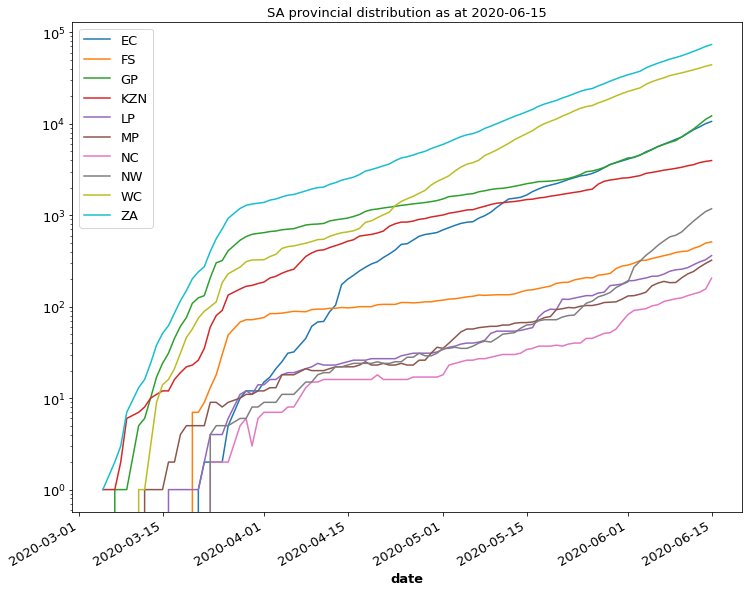

In [48]:


fig = ProvinConf.plot.line(title=f"SA provincial distribution as at {ProvinConf.index[-1].date()}");
fig.semilogy();


## Getting the ZA province population 

In [49]:
def get_SA_Prov_Pop(ToUpdateSAProvince):
    
    '''
    
    This function pulls the population for each provinces
    
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    This function will get the SA provincial population numbers.
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province population dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
        SAProvinPop = pd.read_csv(wget.download(ConfirmedURL, out='za_province_pop.csv'),header=None)
        SAProvinPop.columns = ['Province', 'Pop']
        SAProvinPop['ProvKey'] = ['GP','KZN', 'WC', 'EC','LP', 'MP', 'NW', 'FS', 'NC']
        
    return(SAProvinPop)


updating data


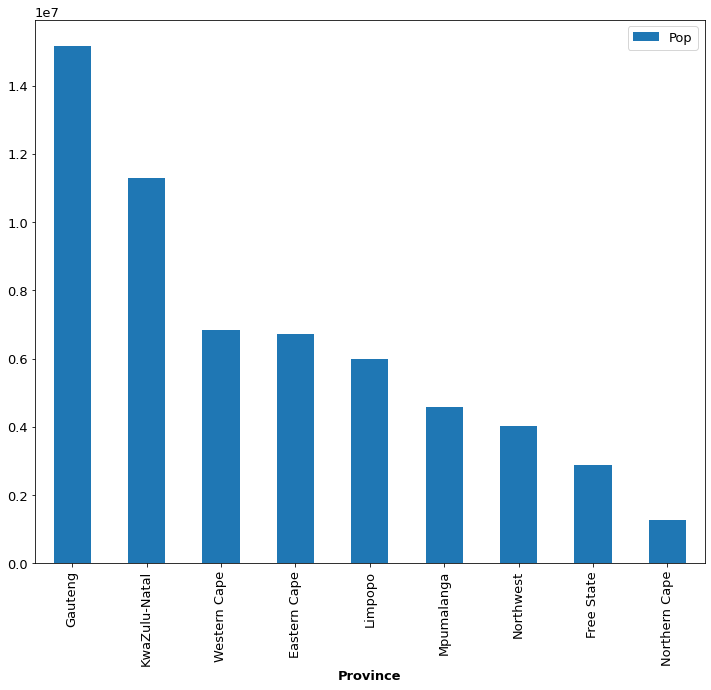

In [50]:
#
# Gettingt the data and doing some plotting 
#
SAProvPop = get_SA_Prov_Pop('y')

SAProvPop.plot(kind='bar',x='Province',y='Pop');

## Getting the Rt calculate values for each province

In [51]:
#
# Taken from Felix updated notebook
#
def get_Rt_lm(DFSeries):
    '''
    This function will calculate the value of Rt for a series.
    In order to calculate R0 we can adapt this 
    https://en.wikipedia.org/wiki/Basic_reproduction_number#Estimation_methods

    Reminder: Rt = R0 when no intervention has been applied and there is mixing
    
    usage get_Rt(pandas_series)
    
    Input:
        Take in a pandas series with time and value
    Output:
        Return the value of R0
    In addition we use a different fitting approach than above
    '''
    import numpy as np
    from lmfit import minimize, Parameters, report_fit # added by [NO]
    
    params = Parameters()
    params.add('a', value=0.)
    params.add('b', value=0.)
    def get_residuals(params, x, data):
        a=params['a'].value
        b=params['b'].value
        model = a * np.exp(b*x)
        return data - model
    
    x = np.arange(len(DFSeries))
    data = list(DFSeries.values)
    out = minimize(get_residuals,params, args = (x,data))
    a = out.params['a'].value
    b = out.params['b'].value
    sigma_b = out.params['b'].stderr
    
    #a = LogisticFit[0][0]
    #b = LogisticFit[0][1] # This is also known as K from description in Wikipedia
    #
    # The dooubling rate is given by T_d
    #
    T_d = np.log(2)/b 
    #
    # We will use the imperial value for tau, this can change later
    #
    tau = 5.1 
    sigma_Rt = (np.exp(b*tau)) * (np.sinh(tau*sigma_b)) #obtaining error for Rt based on error in b
    Rt = np.mean(np.exp(b*tau))
    
    #report_fit(out) # added by [NO]
    
    return (Rt , sigma_Rt, T_d)

In [52]:
#
# To updated Rt based on the exponential fit parameters we run this function after updating the dataframes
#
Recent_prov_Rt = {i: get_Rt_lm(ProvinConf.tail(14)[i]) for i in ProvinConf.columns}

Recent_prov_Rt

{'EC': (1.4389825436179955, 0.008958530651739531, 9.713377453070397),
 'FS': (1.2294053038036954, 0.01009169991957652, 17.116356181550703),
 'GP': (1.54489399333498, 0.028123870881080686, 8.127388399033048),
 'KZN': (1.1705460566618833, 0.004060559533092686, 22.44899124177634),
 'LP': (1.2776792895272648, 0.01675460998347279, 14.42610613507898),
 'MP': (1.419287925550556, 0.027737522273251426, 10.095665473854952),
 'NC': (1.3357279120869188, 0.041138381335778684, 12.211878663294346),
 'NW': (1.7421602584742575, 0.021027741154985236, 6.368016346125389),
 'WC': (1.260619638953143, 0.00942404140270087, 15.263381157146698),
 'ZA': (1.3165849173385944, 0.005166707483298618, 12.852803936380273)}

In [53]:
#
# Using the Rt around the date we starting out forecasting
#

df = ProvinConf.loc[(ProvinConf.index >= '2020-04-23') & (ProvinConf.index < '2020-05-08')]

#df.drop(columns='UNKNOWN', inplace = True)

Recent_prov_RtConf = {i: get_Rt_lm(df.head(14)[i]) for i in df.columns}

Recent_prov_RtConf

RtDfConfirmed = pd.DataFrame(Recent_prov_RtConf).T

RtDfConfirmed.columns = ['Rt','RtSigma_Fit', 'DoublingTime']

RtDfConfirmed

,Rt,RtSigma_Fit,DoublingTime
EC,1.293895,0.014656,13.719981
FS,1.078229,0.005444,46.933607
GP,1.144063,0.006131,26.266179
KZN,1.157276,0.003914,24.201292
LP,1.164512,0.011826,23.210828
MP,1.559735,0.041771,7.952581
NC,1.273062,0.035506,14.642439
NW,1.161857,0.018329,23.563986
WC,1.551838,0.014404,8.044443
ZA,1.321558,0.006733,12.679011


In [54]:
ToUseDeath = False
if ToUseDeath:
    try:
        #
        # In case have already removed this column 
        #
        ProvinDead = ProvinDead.drop(['UNKNOWN','MP','NC','LP','NW'],axis = 1)
    except:
        pass

    Recent_prov_Rt = {i: get_Rt_lm(ProvinDead.tail(14)[i]) for i in ProvinDead.columns}

    Recent_prov_Rt
    
    #
    # Using the Rt around the date we starting out forecasting
    #

    df = ProvinDead.loc[(ProvinDead.index >= '2020-04-23') & (ProvinDead.index < '2020-05-08')]

    #df.drop(columns='UNKNOWN', inplace = True)

    Recent_prov_Rt = {i: get_Rt_lm(df.head(14)[i]) for i in df.columns}


    Recent_prov_Rt

    RtDfDead = pd.DataFrame(Recent_prov_Rt).T

    RtDfDead.columns = ['Rt','RtSigma_Fit', 'DoublingTime']

# SEAI5R

- The SEAI5R model is a variation of the SIR model with inclusion of extra compartments such as the Exposed (E), Activated (A) compartment.

- The activated compartment holds the population of cases that are asymptomatic and infectious.


## Description of the model: 

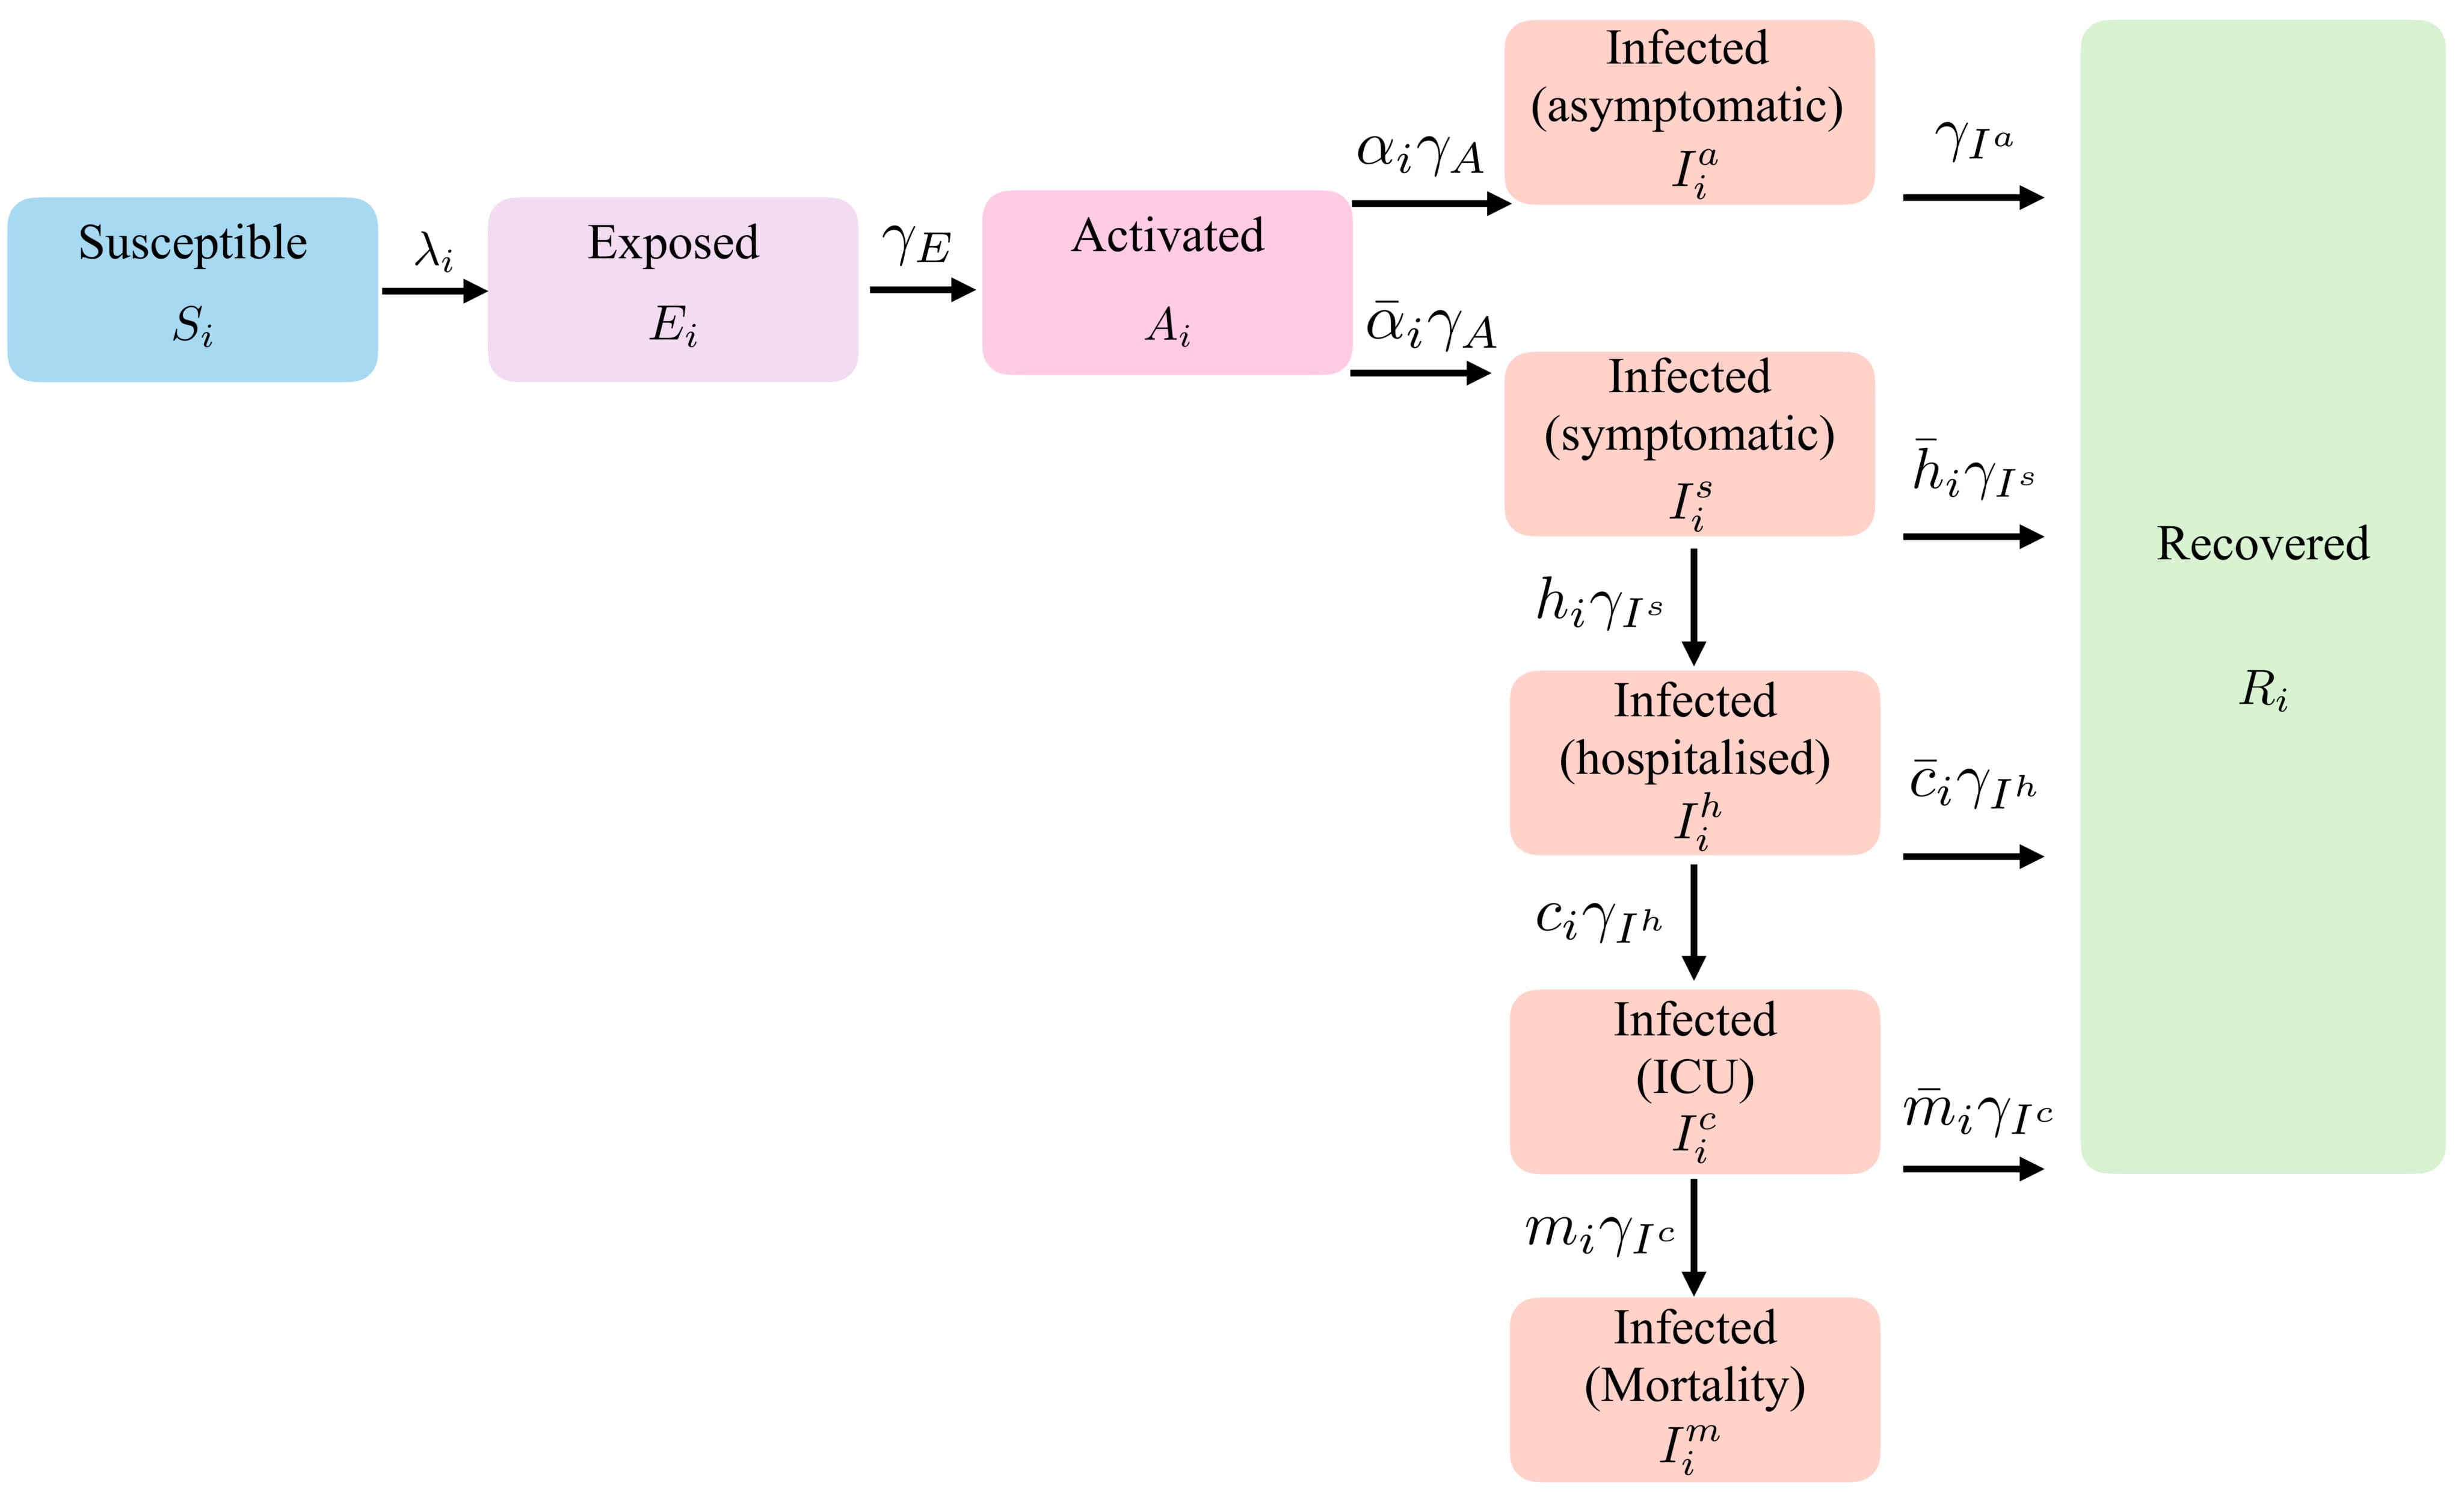


The following parameters are used in this model:

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)
* $\mathrm{hh}$ (rate of infected -> hospitalised)



# Doing a more complex model now pyross.deterministic.SEAI8R for ZA


## 1 - Define model

In [55]:
def contactMatrix_One(t):   
    return np.identity(M)

# Below this cell can be very computer intensive 

### Here we, will create and array with the parameters from an ensemble similar to what we did for the National model.

#### The table below are the values that we have used in our finaldocument

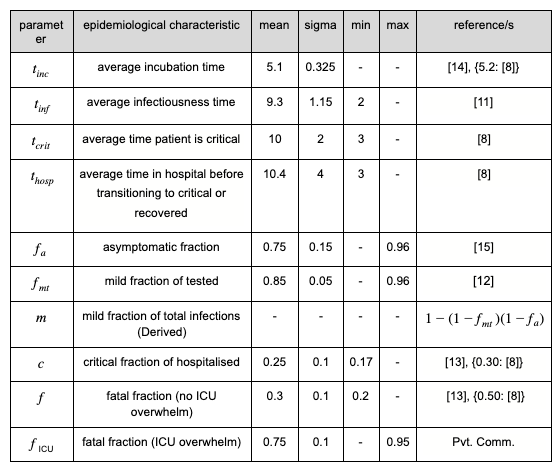

# Model parameter Set up

In [56]:
def ToPlot(ArrayToPlot, TimeArray, DfDead, DateToStart, Ni, title, OutFile):
    '''
    
    This function will take the prediction array and produce the plots similar to the ones we have used in our report
    
    Input:
        ArrayToPlot - this is the array returned from the modelling that hild the varous compartment populations
        TimeArray - array holding the time indices that was used for the prediction
        DfDead - dataframe containing the dead cases for plotting over our fatalities
        DateToStart - date to start plotting fatalities
        title - the title of your plot
    Output:
        Return NoN
    '''
    
    S = ArrayToPlot[:,:,0]     # Susceptible compartment
    E = ArrayToPlot[:,:,1]     # Exposed compartment
    A = ArrayToPlot[:,:,2]     # Activated compartemtn time series
    Ia = ArrayToPlot[:,:,3]    # asymptomatic time series
    Is = ArrayToPlot[:,:,4]    # symptomatic time series
    Ih = ArrayToPlot[:,:,5]    # hospitalised time series
    Ic = ArrayToPlot[:,:,6]    # Critical/ICU time series
    Im = ArrayToPlot[:,:,7]    # mortality time series
    R = ArrayToPlot[:,:,8]     # Removed population time series and is given by R = N(t) - (S + E + A+ Ia + Is + Ih + Ic)

    # cases = (inf + rec + hosp + crit + death) 
    #(All known cases) = (Total population) - (# of suspectibles) + (# of asymptomatics)
    #TotalCases = (Ia + Is + Ih + Ic + Im + R + E + A)
    TotalCases = Ni - S + Ia
    #
    # Plan is to set this as proper date if needed
    #
    #StartDate = datetime.strptime(DateToStart, "%Y-%m-%d")
    #datelist = pd.date_range(StartDate, periods=Tf).tolist()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=72)

    #
    # set uniform characteristics for axes
    #
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        axis.set_ylim(ymin=1, ymax=Ni*1.2)
        axis.set_xlim(0, 365)
        axis.set_yscale('log')
        axis.tick_params(axis='y', labelsize=15);
        axis.hlines([1e+03, 1e+04, 1e+05, 1e+06], xmin=0, xmax=Tf, linestyles='dotted', alpha = 0.6);

    #
    # Doing the plot now
    #
    median_death_list = []
    median_hosp_list = []
    median_critical_list = []
    median_cases_list = []
    
    for i in range(len(ArrayToPlot)):
        ax1.plot(TimeArray, Ic[i,:], 'tab:orange', alpha=0.1, label='Ic - Critical/ICU')
        
        ax2.plot(TimeArray, Im[i,:], 'tab:red', alpha=0.1, label='Im - Fatality')
        ax2.plot(TimeArray, np.median(Im, axis=0), color = 'white', linewidth = '2')
        
        ax3.plot(TimeArray, Ih[i,:], 'dodgerblue', alpha=0.1, label='Ih - Hospitalised')
        
        ax4.plot(TimeArray, TotalCases[i,:], 'tab:blue', alpha=0.1, label='Cases - Total Cases')
        ax4.plot(TimeArray, np.median(TotalCases , axis=0), color = 'white', linewidth = '2')
    #
    # To plot the current dead cases, include the following, by passing this dataframe too
    #
    ax2.plot(DfDead[DfDead.index >= DateToStart].values, 'k', lw=3)

    fig.suptitle(title, fontsize=16)

    ax1.set_title("Individuals in Critical State")
    ax2.set_title("Fatalities")
    ax3.set_title("Individuals in Hospital")
    ax4.set_title(("Total Cases"))


    ax1.set_ylabel('Populations')
    ax3.set_ylabel('Populations')
    ax3.set_xlabel(f"Time [No. days from {DateToStart}]")
    ax4.set_xlabel(f"Time [No. days from {DateToStart}]")
    
    fig.savefig(OutFile)
    
    return()

In [57]:
def plot_hist(comp, colour_to_use, ToPredict, title="Histogram and KDE through scenario ensemble", days = [61,91,153]):
    '''
    This funtion is an adaptation of Richard's histogram plot using KDE
    
    Input:
        comp - Array holding the data to plot
        
    '''
    # plot histogram for specified compartment on various key dates
    # set up the axes, titles, styles, etc
    fig, axes = plt.subplots(2, 2, dpi=72)
    ((ax1, ax2), (ax3, ax4)) = axes
    fig.suptitle(title, fontsize=14)
    ax1.set_title(ToPredict[0].strftime('%d %B'))
    ax2.set_title(ToPredict[1].strftime('%d %B'))
    ax3.set_title(ToPredict[2].strftime('%d %B'))
    ax4.set_title("Maximum")
    plt.tight_layout()

    # set uniform characteristics for axes
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        #print(idx, axis)
        axis.set_yscale('log')
        axis.set_xscale("log")
        axis.tick_params(axis='y', labelsize=12);

        if idx == 3:
            hist_data = comp.max(1)
        else:
            hist_data = comp[:,int(days[idx])]

        ax1.set_ylabel("density", fontsize=10);

        MAX=np.max(hist_data)
        MIN=np.min(hist_data)
        bins = np.logspace(np.log10(MIN), np.log10(MAX), 30)
        x_d = np.linspace(MIN, MAX, hist_data.shape[0])

        axis.hist(hist_data, bins=bins, density=True, histtype='step', linewidth = '2', color=colour_to_use)#, alpha=0.5, log=True)

        #percentiles
        axis.axvline(np.percentile(hist_data, 50), color='red', linewidth = '2', linestyle='solid', alpha=0.85) #ax2.axvline(np.median(h_data), color='g')
        #axis.axvline(np.percentile(hist_data, 84), color='blue', linestyle='dashed', alpha=0.5)
        #axis.axvline(np.percentile(hist_data, 16), color='red', linestyle='dashed', alpha=0.5)
        axis.axvline(np.percentile(hist_data, 97.5), color='blue', linestyle='dashed', alpha=0.75)
        axis.axvline(np.percentile(hist_data, 2.5), color='blue', linestyle='dashed', alpha=0.75)
    
    
    return()


In [58]:

@jit(nopython=True)
def time_varying_reproduction(t):
    
    # Epidemiological parameters
    R_0 = np.random.normal(2.7, 0.35)
    
    # scenario variables
    R_t_1 = np.random.normal(1.14, 0.1) #np.random.normal(1.5335, 0.1)
    R_t_2 = np.maximum(0.85, R_t_1*np.random.normal(1.20, 0.15))
    R_t_3 = np.maximum(0.65, R_t_2*np.random.normal(1.00, 0.20))
    R_t_4 = np.maximum(0.65, R_t_3*np.random.normal(1.00, 0.25))
    R_t_5 = np.maximum(0.65, R_t_4*np.random.normal(0.85, 0.35))

    t_1 = -1
    t_2 = int(np.maximum(31, np.random.normal(60, 7)))
    t_3 = int(np.maximum(61, np.random.normal(90, 7)))
    t_4 = int(np.random.normal(150, 21))
    t_5 = int(np.random.normal(183, 28))

    if t <= t_1:
        # throw warning that default value of R_0 is being used
        print("Using lower default R_0 in time-varying_reproduction function") 
        return (R_0)
    elif t > t_1 and t <= t_2:
        return R_t_1
    elif t > t_2 and t <= t_3:
        return R_t_2
    elif t > t_3 and t <= t_4:
        return R_t_3
    elif t > t_4 and t <= t_5:
        return R_t_4
    elif t > t_5:
        return R_t_5
    else:
        print("Using upper default R_0 in time-varying_reproduction function")
        return R_0


In [59]:
def time_varying_reproduction_en(t):
    
    '''
    This function will return a paramdf based on the date and the Rt values.
    Input:
    
        NoEnsemble - number of ensemble to generate, for now we set this to be only 1
        t - day from starting date
        Rt_ini - Rt value obtained from the fitting
    
    Output: 
        parameter dataframe
    '''
    NoEnsemble = 1
    R_0 = np.random.normal(2.7, 0.35)
    #
    # scenario variables
    #
    R_t_1 = np.random.normal(Rt_ini, 0.1) #np.random.normal(1.5335, 0.1)
    R_t_2 = np.maximum(0.85, R_t_1*np.random.normal(1.20, 0.15))
    R_t_3 = np.maximum(0.65, R_t_2*np.random.normal(1.00, 0.20))
    R_t_4 = np.maximum(0.65, R_t_3*np.random.normal(1.00, 0.25))
    R_t_5 = np.maximum(0.65, R_t_4*np.random.normal(0.85, 0.35))

    t_1 = -1
    t_2 = int(np.maximum(31, np.random.normal(60, 7)))
    t_3 = int(np.maximum(61, np.random.normal(90, 7)))
    t_4 = int(np.random.normal(150, 21))
    t_5 = int(np.random.normal(183, 28))

    if t <= t_1:
        # throw warning that default value of R_0 is being used
        print("Using lower default R_0 in time-varying_reproduction function") 
        params = ToEnsemble(NoEnsemble, R0) # this is where we get the params with proper Rt and beta 
        #
        # intantiate model
        #
        # When M=1, we can re-write ContactMatrix(CM) = (Rt/tinf)*Ni*(1/(beta*(A*Ia+Fsa*(Is+Isp))))
        #
        C = (R0/params['tinf'])*Ni#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
        
        return(C) 
    
    elif t > t_1 and t <= t_2:
        params = ToEnsemble(NoEnsemble,  R_t_1)
        #
        # intantiate model
        #
        C = (R_t_1/params['tinf'])*Ni#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
        
        return(C) 
    
    elif t > t_2 and t <= t_3:
        params = ToEnsemble(NoEnsemble,  R_t_2)
        #
        # intantiate model
        #
        C = (R_t_2/params['tinf'])*Ni#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
        
        return(C)
    
    elif t > t_3 and t <= t_4:
        params = ToEnsemble(NoEnsemble,  R_t_3)
        #
        # intantiate model
        #
        C = (R_t_3/params['tinf'])*Ni#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
        
        return(C)
    elif t > t_4 and t <= t_5:
        params = ToEnsemble(NoEnsemble,  R_t_4)
        #
        # intantiate model
        #
        C = (R_t_4/params['tinf'])*Ni#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
        
        return(C)
    
    elif t > t_5:
        params = ToEnsemble(NoEnsemble,  R_t_5)
        #
        # intantiate model
        #
        C = (R_t_5/params['tinf'])*Ni#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
        
        return(C)
    else:
        print("Using upper default R_0 in time-varying_reproduction function")
        params = ToEnsemble(NoEnsemble, R0) 
        #
        # intantiate model
        #
        C = (R0/params['tinf'])*Ni#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))                              
        return(C) # params with Rt = R0


In [60]:

#@jit(nopython=True)
def Rt_ensemble(Nums, model_days):

    #Take in number of simulation and model days to return the time array.

    t_arr = np.empty((Nums, model_days),dtype=np.float64)
    
    for i in range(Nums):
        
        t = np.empty(model_days)

        for j in range(model_days):

            t[j] = time_varying_reproduction(j)
            
        t_arr[i,:] = t
        
    return(t_arr)



In [61]:
'''lala = []
for days in range(365):
    lala.append(time_varying_reproduction_en(1, days, 2.7))
'''

'lala = []\nfor days in range(365):\n    lala.append(time_varying_reproduction_en(1, days, 2.7))\n'

In [62]:
#lala[0]

In [63]:
'''blala = []
for days in range(365):
    blala.append(Rt_ensemble(10,days))'''

'blala = []\nfor days in range(365):\n    blala.append(Rt_ensemble(10,days))'

In [141]:
#
# Model parameters set up, each parameter names will be a column and the number of ensemble will be the rows
#
def ToEnsemble(NoIteration, Rt_tmp):
    '''
    This function will create and ensemble of paramters that will be stored in a dataframe and passed onto 
    the modelling function. 
    
    Input:
        NoIteration - no of sample to generate
        Rt_tmp - initial value of Rt to use 
    Output:
        ModelParamDf - dataframe containing the parameters used
    '''
    alpha  = []
    Rt     = [] ; tinf   = [] ; beta   = []
    t_incu = []
    gE     = []; gA     = []; gIa    = []; gIs    = []
    fsa    = []; fh     = []
    gIh    = []; gIc    = []; gIsp   = []; gIhp   = []; gIcp   = []

    for i in range(NoIteration):
        
        R_0 = np.random.normal(2.7, 0.35)                    # This is not used fully yet
        
        alpha_tmp = np.minimum(0.96, np.random.normal(0.75, 0.15)) # fraction of infected who are asymptomatic, fa
        alpha.append(alpha_tmp)                         

        beta_tmp  = 1.                                         # Uncomment to use infection rate for South Africa from 
                                                              # https://www.medrxiv.org/content/10.1101/2020.04.18.20070771v2
                                                              # beta = Rt/tinf
        Rt.append(Rt_tmp)                                     # using the value we used in our original model

        tinf_tmp = np.maximum(2, np.random.normal(9.3, 1.15)) # t_infect = np.maximum(3,np.random.normal(9.3, 1.15)) NB - changed to range over which density 
                                                              # of infectiousness was 1%
        tinf.append(tinf_tmp)                                 # infectious time
        beta.append(beta_tmp)
        #beta.append(Rt_tmp/tinf_tmp)
        
        t_incu_tmp = np.random.normal(5.1, 0.325)             # average incubation period: "median incubation period was estimated to be 5.1 days 
                                                              # (95% CI, 4.5 to 5.8 days) https://www.acpjournals.org/doi/10.7326/M20-0504                           
        t_incu.append(t_incu_tmp)
        gE.append(1./t_incu_tmp)                              # rate of removal of Exposed, aka 1/t_incu 

        gA_tmp = np.random.normal(2., 0.5)                    # rate of removal of Activated, i.e time from onset of infectiousness to onset of symptoms
        gA.append(1./gA_tmp) 
        
        gIa_tmp = np.maximum(6, np.random.normal(2, 3))       # rate of removal of asymptomatic infectives, based from
                                                              # https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2766237
        gIa.append(1./gIa_tmp)                      
        
        gIs_tmp = tinf_tmp                                    # rate of removal of symptomatic infectives, linked to t_inf
        gIs.append(1./gIs_tmp)                      


        fsa    = 0.01                                           # the self-isolation parameter   
        fh     = 0.2                                          # fraction by which hospitalised individuals are isolated

        gIh_tmp = np.maximum(3, np.random.normal(10.4, 4))    # rate of removal for hospitalised individuals, related to t_hosp
        gIh.append(1./gIh_tmp)                     
        
        gIc_tmp = np.maximum(3, np.random.normal(10, 2))      # related to t_cric
        gIc.append(1./gIc_tmp)                                # rate of removal for idividuals in intensive care
    
        #
        # The buffer is basicaly the compartment prior to recovered and used in SEAI8R
        # 
        
        #gIsp_tmp = 12.
        #gIsp.append(1./gIsp_tmp)                              # rate of removal from symptomatic individuals towards buffer

        #gIhp_tmp = np.maximum(3, np.random.normal(10.4, 4))
        #gIhp.append(1./gIhp_tmp)                              # rate of removal from hospitalised individuals towards buffer

        #gIcp_tmp = np.maximum(3, np.random.normal(10, 2))
        #gIcp.append(1./gIcp_tmp)                              # rate of removal from ICU individuals towards buffer


    #ModelParamDf = pd.DataFrame({'alpha':alpha,'Rt': Rt, 'tinf': tinf, 'beta':beta, 't_incu':t_incu,
    #                             'gE': gE, 'gA': gA, 'gIa':gIa, 'gIs':gIs,'fsa':fsa, 
    #                             'fh':fh, 'gIh':gIh,'gIc':gIc, 'gIsp':gIsp, 'gIhp':gIhp, 
    #                             'gIcp':gIcp}, 
    #                            columns = ['alpha', 'Rt', 'tinf', 'beta', 't_incu', 
    #                                       'gE', 'gA', 'gIa', 'gIs', 'fsa', 'fh', 'gIh',
    #                                       'gIc', 'gIsp', 'gIhp', 'gIcp'])
    ModelParamDf = pd.DataFrame({'alpha':alpha,'Rt': Rt, 'tinf': tinf, 'beta':beta, 't_incu':t_incu,
                                 'gE': gE, 'gA': gA, 'gIa':gIa, 'gIs':gIs,'fsa':fsa, 
                                 'fh':fh, 'gIh':gIh,'gIc':gIc}, 
                                columns = ['alpha', 'Rt', 'tinf', 'beta', 't_incu', 
                                           'gE', 'gA', 'gIa', 'gIs', 'fsa', 'fh', 'gIh',
                                           'gIc'])
    return(ModelParamDf)

In [142]:
def MyContact(LockBound, ToDoContact):
    #
    # ToDo a contactmatrix for SouthAfrica provinces
    #
    # pyross.contactMatrix.ContactMatrixFunction?
    # CH:  constant matrix at home
    # CW:  constant matrix at work
    # CS:  constant matrix at school
    # CO:  constant matrix at other locations
    #


    if ToDoContact:
        #
        # Get individual contact matrices
        #
        #CH, CW, CS, CO = pyross.contactMatrix.India()
        print("Downloading contact dataset")
        
        url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CH.csv'
        CH = np.genfromtxt((wget.download(url, out = 'CH.csv')),delimiter = ',' ,skip_header = 0)
        url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CW.csv'
        CW = np.genfromtxt((wget.download(url, out = 'CW.csv')),delimiter = ',' ,skip_header = 0)
        url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CS.csv'
        CS = np.genfromtxt((wget.download(url, out = 'CS.csv')),delimiter = ',' ,skip_header = 0)
        url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CO.csv'
        CO = np.genfromtxt((wget.download(url, out = 'CO.csv')),delimiter = ',' ,skip_header = 0)

        #
        # matrix of total contacts
        #
        C = CH+CW+CS+CO
        #
        # Generate class with contact matrix for SIR model with South Africa contact structure
        #
        generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)

        alpha = 1
        aH1, aW1, aS1, aO1 = [i * alpha for i in [1.0,1.0,1.0,1.0]]
        aH2, aW2, aS2, aO2 = [(i * alpha**2) for i in [1.0,1.0,1.0,1.0]]
        aH3, aW3, aS3, aO3 = [(i * alpha**3) for i in [1.0,1.0,1.0,1.0]]
        aH4, aW4, aS4, aO4 = [(i * alpha**4) for i in [1.0,1.0,1.0,1.0]]
    
        #
        # prefactors for CW, CS, CO:
        #
        interventions = [[1.0, 1.0, 1.0, 1.0],      # before first time
                         [aH1, aW1, aS1, aO1],      # between first and second time
                         [aH2, aW2, aS2, aO2],      # between second and third
                         [aH3, aW3, aS3, aO3],
                         [aH4, aW4, aS4, aO4]
                        ]         

        # generate corresponding contact matrix function
        contactMatrix = generator.interventions_temporal(times=LockBound,interventions=interventions)


    else:
        def contactMatrix(t):   
            return np.identity(M)
        
    print("Done")

    return(contactMatrix)

In [181]:

def MyModel(NoIteration, ParamDf, NoConfirmed, NoRecovered, NoDead, M,Tf, Nf, Ni):
    NZA = 59156682 
    '''
    This function is used to instantiate the model again for ensemble and do the deterministic model
    
    Input:
        NoIteration - Number of iterations to run (which should be <= Number of iteration used to generate ensemble)
        ParamDf - dataframe containing the ensemble paramters
        M, Tf, Nf, Ni - parameters explained earlier 
    Output:
        trajectories_s - series for the prediction for each compartment 
        trajectories_time - time series from prediction
    
    '''

    NoCompartment = 9                                             # Total number of compartments we have in our model
    trajectories_s = np.zeros([NoIteration, Nf, 9*M],dtype=float) # setting array to hold our results

    for i in range(NoIteration):
        if i%100 == 99: 
            #print('Got to run: ', i+1)
            print('Ran {0} simulation out of {1}'.format(i+1,NoIteration),end='\r')
        #
        # intantiate model
        #

        A_0   = np.zeros((M))
        
        #
        #Ia_0  initial asymptomatic cases
        #

        frac_asymptomatic = ParamDf['alpha'].values[0] # 5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/

        #
        # total cases - recovered: 5951 - 2498
        #
        n_tested_active   = NoConfirmed - NoRecovered

        Ia_0              = (n_tested_active * (1./(1.-frac_asymptomatic)))*np.ones((M)) 

        #
        # initial symptomatic cases
        #
        
        Is_0  = NoConfirmed*np.ones((M))
        Isp_0 = np.zeros((M))

        #
        # initial hospitalised cases
        #
        
        Ih_0  = 411*np.ones((M))*Ni/NZA                       # this is national number as at 2 May 2020 for ZA            
        Ihp_0 = np.zeros((M))

        #
        # initial icu patients
        #
        
        NoICU = 35 *(Ni/6844272)                              # Number of patients in ICU for WC as on 1 May 35 in ICU
        Ic_0  = NoICU*np.ones((M))                
    
        #
        # initial mortality cases
        #
        Im_0  = NoDead*np.ones((M))

        #
        # initialising the E cases
        #

        #E_0   = Ia_0 * 1.7                     # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected
        E_0   = ((Ia_0+Is_0)*ParamDf['Rt'].values[0]**2)*np.ones((M))   # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected

        #
        # assume no removed individuals
        #
        #n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))
        R_0   = (NoConfirmed - n_tested_active)*\
                (1/(1-frac_asymptomatic))*np.ones(M)

        S_0   = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 + Im_0  + R_0)

        #
        # The following parameters are vry critical to the model
        #

        sa   = 0.2*np.zeros(M)      # daily arrival of new susceptibles - (birth rate around 2%)
                                    # sa can also be the rate of additional/removal of population by birth etc

        #frac_asymptomatic = #np.minimum(0.96, np.random.normal(0.75, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
        frac_tested_mild = np.minimum(0.96, np.random.normal(0.8, 0.05)) # ratio of tested infections that are mild. [CCDC]
        #hh   = ((1.-frac_asymptomatic) * (1 - 0.96))*np.ones(M)


        #hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital, (1 - m_a)
        hh   = (1.-((1.-frac_asymptomatic) * (1 - frac_tested_mild)))*np.ones(M)

        cc   = 0.25*np.ones(M)      # fraction sent to ICU from hospitalised, this has an impact on the dip was seeing in the critical state,c_a
        #cc   = np.minimum(0.17, np.random.normal(0.25, 0.1))*np.ones(M)

        #mm   = 0.75*np.ones(M)        # mortality rate in ICU, aka IFR !!!, f_a
        mm   = np.minimum(0.2, np.random.normal(0.3, 0.1))*np.ones(M)

        '''parameters = {'alpha':ParamDf['alpha'].values,
                      'beta' :ParamDf['beta'].values, 
                      'gIa'  :ParamDf['gIa'].values,
                      'gIs'  :ParamDf['gIs'].values,
                      'gIh'  :ParamDf['gIh'].values,
                      'gIc'  :ParamDf['gIc'].values,
                      'gE'   :ParamDf['gE'].values,
                      'gA'   :ParamDf['gA'].values,
                      'fsa'  :ParamDf['fsa'].values,
                      'fh'   :ParamDf['fh'].values, 
                      'gIsp' :ParamDf['gIsp'].values, 
                      'gIcp' :ParamDf['gIcp'].values, 
                      'gIhp' :ParamDf['gIhp'].values,
                      'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}'''
        
        parameters = {'alpha':ParamDf['alpha'].values,
                      'beta' :ParamDf['beta'].values, 
                      'gIa'  :ParamDf['gIa'].values,
                      'gIs'  :ParamDf['gIs'].values,
                      'gIh'  :ParamDf['gIh'].values,
                      'gIc'  :ParamDf['gIc'].values,
                      'gE'   :ParamDf['gE'].values,
                      'gA'   :ParamDf['gA'].values,
                      'fsa'  :ParamDf['fsa'].values,
                      'fh'   :ParamDf['fh'].values, 
                      'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
        
        model = pyross.deterministic.SEAI5R(parameters, M, Ni)
        
        #
        # The Rt varying should come here
        #
        def ContactMatrix(t):
            '''
            This function will return a paramdf based on the date and the Rt values.
            Input:

                NoEnsemble - number of ensemble to generate, for now we set this to be only 1
                t - day from starting date
                Rt_ini - Rt value obtained from the fitting

            Output: 
                parameter dataframe
            '''
            NoEnsemble = 1
            R_0 = np.random.normal(2.7, 0.35)
            Rt_ini = 1.32
            M=1
            #
            # scenario variables
            #
            R_t_1 = np.random.normal(Rt_ini, 0.1) #np.random.normal(1.5335, 0.1)
            R_t_2 = np.maximum(0.85, R_t_1*np.random.normal(1.20, 0.15))
            R_t_3 = np.maximum(0.65, R_t_2*np.random.normal(1.00, 0.20))
            R_t_4 = np.maximum(0.65, R_t_3*np.random.normal(1.00, 0.25))
            R_t_5 = np.maximum(0.65, R_t_4*np.random.normal(0.85, 0.35))

            t_1 = -1
            t_2 = int(np.maximum(31, np.random.normal(60, 7)))
            t_3 = int(np.maximum(61, np.random.normal(90, 7)))
            t_4 = int(np.random.normal(150, 21))
            t_5 = int(np.random.normal(183, 28))
            #print("t ", t)
            if t <= t_1:
                # throw warning that default value of R_0 is being used
                print("Using lower default R_0 in time-varying_reproduction function") 
                params = ToEnsemble(NoEnsemble, R0) # this is where we get the params with proper Rt and beta 
                #
                # intantiate model
                #
                # When M=1, we can re-write ContactMatrix(CM) = (Rt/tinf)*Ni*(1/(beta*(A*Ia+Fsa*(Is+Isp))))
                #
                C = (R0/params['tinf'].values)*np.identity(M)#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
                #print("t0 ", C)
                return(C) 

            elif t > t_1 and t <= t_2:
                params = ToEnsemble(NoEnsemble,  R_t_1)
                #
                # intantiate model
                #
                C = (R_t_1/params['tinf'].values)*np.identity(M)#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
                #print("t1 ", C)
                return(C) 

            elif t > t_2 and t <= t_3:
                params = ToEnsemble(NoEnsemble,  R_t_2)
                #
                # intantiate model
                #
                C = (R_t_2/params['tinf'].values)*np.identity(M)#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
                #print("t2 ", C)
                return(C)

            elif t > t_3 and t <= t_4:
                params = ToEnsemble(NoEnsemble,  R_t_3)
                #
                # intantiate model
                #
                C = (R_t_3/params['tinf'].values)*np.identity(M)#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
                #print("t3 ", C)
                return(C)
            elif t > t_4 and t <= t_5:
                params = ToEnsemble(NoEnsemble,  R_t_4)
                #
                # intantiate model
                #
                C = (R_t_4/params['tinf'].values)*np.identity(M)#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
                #print("t4 ", C)
                return(C)

            elif t > t_5:
                params = ToEnsemble(NoEnsemble,  R_t_5)
                #
                # intantiate model
                #
                C = (R_t_5/params['tinf'].values)*np.identity(M)#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))
                #print("t5 ", C)
                return(C)
            else:
                print("Using upper default R_0 in time-varying_reproduction function")
                params = ToEnsemble(NoEnsemble, R0) 
                #
                # intantiate model
                #
                C = (R0/params['tinf'].values)*np.identity(M)#*(1./(params['beta']*(A*Ia+Fsa*(Is+Isp))))                              
                return(C) # params with Rt = R0
        
        def ContactMatrix1(t):  
            
            return np.identity(M)

        #data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, ContactMatrix,Tf, Nf, Ti=0,
        #                       integrator='odespy-rk4', maxNumSteps=5)
        data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, ContactMatrix,Tf, Nf, Ti=0,
                               integrator='odespy-rk4', maxNumSteps=50)
        
        trajectories_s[i] = data['X']
        trajectories_time =  data['t']
    
    return(trajectories_s, trajectories_time)
    

## Start running from here if nothing changed in functions


In [182]:
M     = 1                             # Number of compartments of individual for each class,
                                      # the SIR model has no age structure for now
Ni    = NZA*np.ones(M)                # Initial number in each compartment and class
N     = np.sum(Ni)                    # and the total population is the size of this age group

DateToStart = '2020-05-01'            # Date to start the prediction since recovered value missing

#Tf = 365                              # Final time of integrator i.e 365 days long

#Nf = 1*Tf                              # Number of time points to sample within Tf   

#model_days = 365; Tf = 1; Nf = 3*Tf

In [183]:
#
# This is testing for National values, change Rt initial if required
# 
Nums = 5 # for ensemble


In [184]:
'''def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    elif 42<=t<47:
        xx = C
    elif 47<=t<75:
        xx = CH
    else:
        xx = C
    return xx

MyLock = [31, 62, 150, 183]

#MyContactMatrix = MyContact(MyLock, True)

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=MyLock,interventions=interventions)'''

'def contactMatrix(t):\n    if t<21:\n        xx = C\n    elif 21<=t<42:\n        xx = CH\n    elif 42<=t<47:\n        xx = C\n    elif 47<=t<75:\n        xx = CH\n    else:\n        xx = C\n    return xx\n\nMyLock = [31, 62, 150, 183]\n\n#MyContactMatrix = MyContact(MyLock, True)\n\n# generate corresponding contact matrix function\nC = generator.interventions_temporal(times=MyLock,interventions=interventions)'

In [185]:
ToPlotRt = False
if ToPlotRt:
    for i in range(Nums):
        plt.plot(RtVal[i,:], color='blue', alpha=0.035)
    plt.ylabel("$R_t$", fontsize = 16);
    plt.xlabel("Day (from 1 May 2020)", fontsize = 14);


In [186]:
#ParamDf = ToEnsemble(Nums, Rt_initial=2.4)

#ParamDf.head()

#ParamDf.Rt.plot(kind='hist',bins=25);
#plt.xlabel("Rt values")

## Now running for one Province 

In [187]:
model_days = 365
Tf = model_days
Nf = 3*Tf
Nums = 500

In [188]:
province = input(f"Enter province name of [ZA] from above names {SAProvPop.ProvKey.unique()}") 
#
# Get the number of cases at the date we start our prediction
#ii
ConfirmedVal = ProvinConf[ProvinConf.index == DateToStart][province].values[0]
RecoveredVal = ProvinRecover[ProvinRecover.index == DateToStart][province].values[0]
DeadVal = ProvinDead[ProvinDead.index == DateToStart][province].values[0]

if province == 'ZA':
    Ni = np.array([NZA]) # SAProvPop.Pop.sum() - 58820020
else:
    Ni = SAProvPop[SAProvPop['ProvKey'] == province]['Pop'].values

DeadDf = pd.DataFrame(ProvinDead[province])

print(f"Total population in {province} = {Ni[0]:,d}")

print(f"Current Rt value used from data is {Recent_prov_RtConf[province][0]:.3}")

#print(f"\nRt values used for {province}\n")


print("\n### Running prediction model now ###\n")


Scenario = []

for i in range(Nums):
    if i%100 == 99: 
        print('Got to run: ', i+1)
    #
    # Create a dataframe for the dead case for plotting
    #
    #DeadDf = pd.DataFrame(ProvinDead[province])
    #
    # First we genrate the param file
    #
    #paramDf = time_varying_reproduction(1, 32, 1.3) # 1 ensemble, day 32 to calculate Rt, Rt_initial
    
    paramDf = ToEnsemble(1, Recent_prov_Rt[province][0])

    #
    # Now runing the model prediction
    #
    
    temp, tempT = MyModel(1, paramDf, ConfirmedVal, RecoveredVal, DeadVal, M, model_days, Nf, Ni) # run the model only once
   
    Scenario.append(temp)
    
Scenario = (np.median(np.array(Scenario),axis=1))

print("Done", Scenario.shape)

Enter province name of [ZA] from above names ['GP' 'KZN' 'WC' 'EC' 'LP' 'MP' 'NW' 'FS' 'NC'] ZA


Total population in ZA = 59,156,682
Current Rt value used from data is 1.32

### Running prediction model now ###

Got to run:  100
Got to run:  200
Got to run:  300
Got to run:  400
Got to run:  500
Done (500, 1095, 9)


In [193]:
#for i in range(Nums):
#    plt.plot(tempT, np.array(Scenario)[i,:,7],'r',alpha=0.25);
#plt.semilogy()

()

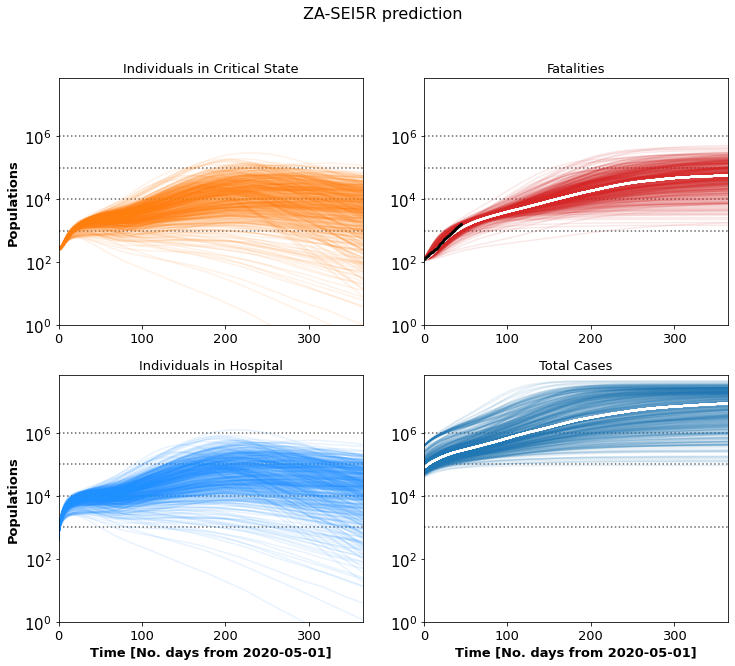

In [194]:
OutFile = "Intervention_Test.png"
ToPlot(Scenario, tempT, DeadDf, DateToStart,Ni, province+"-SEI5R prediction", OutFile)

# Doing the KDE histogram plot 

## The histogram will be plotted for 15 June, 15 July, 15 August and also the total for the year

In [195]:
#
# This is what we need for infectious - need to confirm with Rochard
# SwapAxes[:,compartment_labels.index(show_labels[0]),:]+SwapAxes[:,compartment_labels.index(show_labels[1]),:]
#

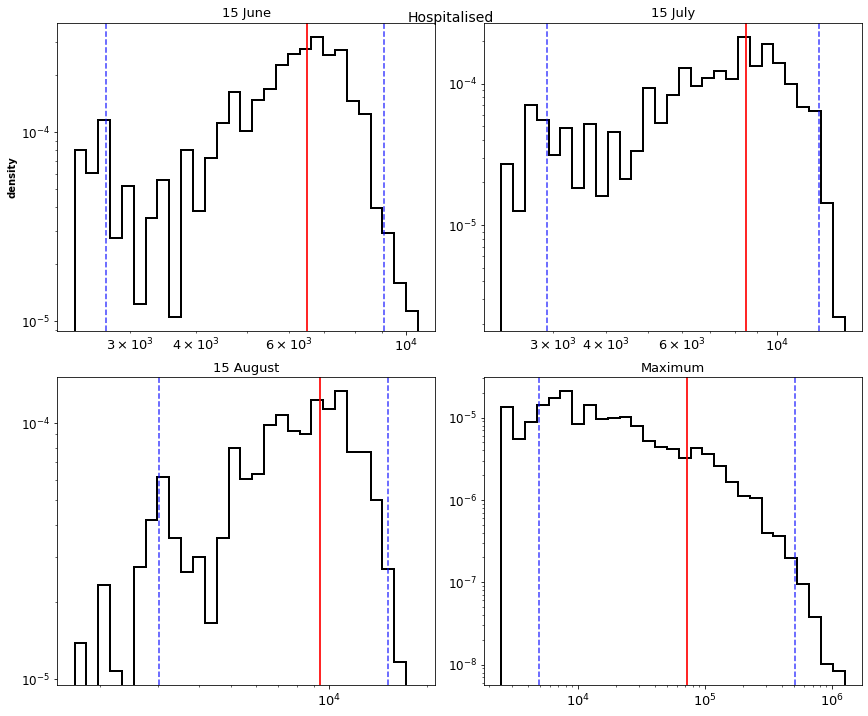

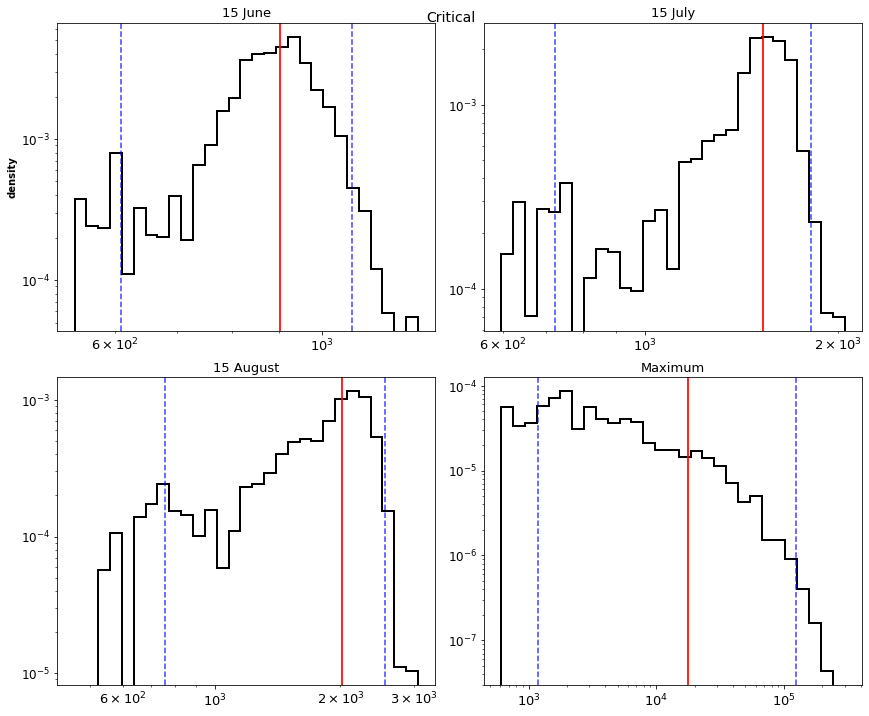

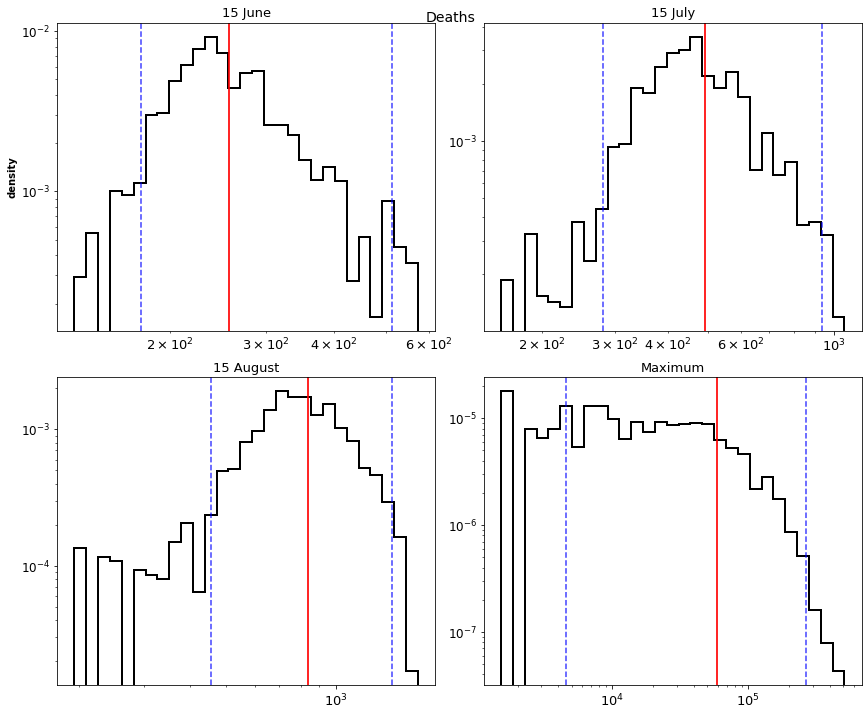

In [196]:
#
# Swap my axes to be in-line as Richard's function requirements
#
SwapAxes = np.swapaxes(Scenario,1,2)

#SwapAxes.shape

#is_arr = np.empty([N_RUNS, sol.y.shape[0], sol.y.shape[1]])

colorvec = ['orange','red','dodgerblue','blue']

#for idx, sol in enumerate(i_scenarios):
#    is_arr[idx,:,:] = sol.y
# My SwapAxes array is already in this shape of is_arr

#
# days of evaluation should correspond to [1 June, 1 July, 1 September]
#

first_date = datetime.strptime(DateToStart, '%Y-%m-%d')
last_date0 = datetime.strptime('2020-6-15', '%Y-%m-%d')
last_date1 = datetime.strptime('2020-7-15', '%Y-%m-%d')
last_date2 = datetime.strptime('2020-8-15', '%Y-%m-%d') 
DatesToPredict = [last_date0 ,last_date1, last_date2]

eval_days = [(last_date0 - first_date).days,(last_date1 - first_date).days,(last_date2 - first_date).days]

#
# In our model we get the folllowing: S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, R
#
# S = ArrayToPlot[:,:,0]
# E = ArrayToPlot[:,:,1]
# A = ArrayToPlot[:,:,2]
# Ia = ArrayToPlot[:,:,3]
# Is = ArrayToPlot[:,:,4]
# Ih = ArrayToPlot[:,:,5]
# Ic = ArrayToPlot[:,:,6]
# Im = ArrayToPlot[:,:,7]
# R = ArrayToPlot[:,:,8]

    
#compartment_labels = ['Susceptible', 'Exposed', 'Infectious', 'Recovered', 'Hospitalised', 'Critical', 'Deaths']
compartment_labels = ['Susceptible', 'Exposed', 'Activated', 'Infected Asymptomatic', 'Infected Symptomatic', 'Hospitalised', 'Critical', 'Deaths', 'Recovered']
show_labels = ['Hospitalised', 'Critical', 'Deaths']

#for idx, scen in enumerate(np.rollaxis(is_arr[:,[compartment_labels.index(show_labels[0]), 
#                                                 compartment_labels.index(show_labels[1]), 
#                                                 compartment_labels.index(show_labels[2]), 
#                                                 compartment_labels.index(show_labels[3])],:], 1)):    
for idx, scen in enumerate(np.rollaxis(SwapAxes[:,[compartment_labels.index(show_labels[0]), 
                                                 compartment_labels.index(show_labels[1]), 
                                                 compartment_labels.index(show_labels[2])],:], 1)): 
    colour_plot = 'k' #colorvec[idx-1]
    
    plot_hist(scen, colour_plot, DatesToPredict,  title = show_labels[idx], days=eval_days)

    plt.savefig(province+"_Temp_KDE"+show_labels[idx]+".png")
# for reference: sus, exp, inf, rec, hosp, crit, death = solution.y
# cases = (inf + rec + hosp + crit + death) 

In [197]:
print(f"Death as as at {ProvinDead.index[-1].date()}: {ProvinDead[province].iloc[-1]}")

Death as as at 2020-06-15: 1568


## The cell below is for looping into all the provinces

In [ ]:
ToLoopAll = True

Nums = 2000

#
# Which Rt values to use, the confirmed cases of the deadth
#


In [ ]:

if ToLoopAll:

    for province  in SAProvPop.ProvKey.unique():
        
        #
        # First calculate ParamDf, e.g. using Rt for WC
        #
        ParamDf = ToEnsemble(Nums, Recent_prov_Rt[province][0])
        #
        # Get the number of cases at the date we start our prediction
        #
        ConfirmedVal = ProvinConf[ProvinConf.index == DateToStart][province].values[0]
        RecoveredVal = ProvinRecover[ProvinRecover.index == DateToStart][province].values[0]
        DeadVal = ProvinDead[ProvinDead.index == DateToStart][province].values[0]
        #
        # Create a dataframe for the dead case for plotting
        #
        DeadDf = pd.DataFrame(ProvinDead[province])

        if province == 'ZA':
            Ni = np.array([NZA]) # SAProvPop.Pop.sum() - 58820020
        else:
            Ni = SAProvPop[SAProvPop['ProvKey'] == province]['Pop'].values

        print(f"Total population in {province} = {Ni[0]:,d}")

        print(f"Initial Rt value using past 14 days data is {Recent_prov_Rt[province][0]:.3}")

        print(f"\nRt values used for {province}\n")
        print(ParamDf.Rt.describe())

        ParamDf.Rt.plot(kind='hist',bins=25, alpha=0.5); plt.xlabel("Rt values");

        #
        # Now runing the model prediction
        #

        print("\n### Running prediction model now ###\n")

        MyPredict, MyPredictTime = MyModel(Nums, ParamDf, ConfirmedVal, RecoveredVal, DeadVal, M,  Tf, Nf, Ni)

        #CriticalDf = pd.DataFrame(MyPredict[:,:,6].T)
        #CriticalDf.loc[0:].plot(color='r',alpha=0.1, logy=True,legend=False);

        #
        # Plotting the results
        #
        OutFile = "PySEI5R_Province_"+province+"_SEI5R_prediction.png"
        ToPlot(MyPredict, MyPredictTime, DeadDf, DateToStart,Ni, province+"-SEI5R prediction", OutFile)
    
        #
        # Swap my axes to be in-line as Richard's function requirements for KDE
        #
        SwapAxes = np.swapaxes(MyPredict,1,2)

        #SwapAxes.shape

        #is_arr = np.empty([N_RUNS, sol.y.shape[0], sol.y.shape[1]])

        colorvec = ['orange','red','dodgerblue','blue']

        #for idx, sol in enumerate(i_scenarios):
        #    is_arr[idx,:,:] = sol.y
        # My SwapAxes array is already in this shape of is_arr

        #
        # days of evaluation should correspond to [1 June, 1 July, 1 September]
        #

        first_date = datetime.strptime(DateToStart, '%Y-%m-%d')
        last_date0 = datetime.strptime('2020-6-15', '%Y-%m-%d')
        last_date1 = datetime.strptime('2020-7-15', '%Y-%m-%d')
        last_date2 = datetime.strptime('2020-8-15', '%Y-%m-%d') 
        DatesToPredict = [last_date0 ,last_date1, last_date2]

        eval_days = [(last_date0 - first_date).days,(last_date1 - first_date).days,(last_date2 - first_date).days]

        #
        # In our model we get the folllowing: S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, R
        #
        # S = ArrayToPlot[:,:,0]
        # E = ArrayToPlot[:,:,1]
        # A = ArrayToPlot[:,:,2]
        # Ia = ArrayToPlot[:,:,3]
        # Is = ArrayToPlot[:,:,4]
        # Ih = ArrayToPlot[:,:,5]
        # Ic = ArrayToPlot[:,:,6]
        # Im = ArrayToPlot[:,:,7]
        # R = ArrayToPlot[:,:,8]


        #compartment_labels = ['Susceptible', 'Exposed', 'Infectious', 'Recovered', 'Hospitalised', 'Critical', 'Deaths']
        compartment_labels = ['Susceptible', 'Exposed', 'Activated', 'Infected Asymptomatic', 'Infected Symptomatic', 'Hospitalised', 'Critical', 'Deaths', 'Recovered']
        show_labels = ['Hospitalised', 'Critical', 'Deaths']

        #for idx, scen in enumerate(np.rollaxis(is_arr[:,[compartment_labels.index(show_labels[0]), 
        #                                                 compartment_labels.index(show_labels[1]), 
        #                                                 compartment_labels.index(show_labels[2]), 
        #                                                 compartment_labels.index(show_labels[3])],:], 1)):    
        for idx, scen in enumerate(np.rollaxis(SwapAxes[:,[compartment_labels.index(show_labels[0]), 
                                                         compartment_labels.index(show_labels[1]), 
                                                         compartment_labels.index(show_labels[2])],:], 1)): 
            colour_plot = 'k' #colorvec[idx-1]

            plot_hist(scen, colour_plot, DatesToPredict, title = province+'_'+show_labels[idx]+'_histogram', days=eval_days)
            
            plt.savefig("PySEI5R_Province_"+province+"_"+show_labels[idx]+"_SEI5R_prediction_KDE.png")

# for reference: sus, exp, inf, rec, hosp, crit, death = solution.y
# cases = (inf + rec + hosp + crit + death) 


## Attempting fpdf below for writing report:

### Writing everything into a pdf file

In [ ]:
ToPdf = False

if ToPdf:
    from fpdf import FPDF

    pdf = FPDF(orientation = 'P', unit = 'mm', format='A4')
    pdf.alias_nb_pages()
    pdf.set_font('Arial', style = '', size=12)


    for province  in SAProvPop.ProvKey.unique():
        pdf.add_page()
        #
        # First calculate ParamDf, e.g. using Rt for WC
        #
        ParamDf = ToEnsemble(Nums, Recent_prov_Rt[province][0])
        #
        # Get the number of cases at the date we start our prediction
        #
        ConfirmedVal = ProvinConf[ProvinConf.index == DateToStart][province].values[0]
        RecoveredVal = ProvinRecover[ProvinRecover.index == DateToStart][province].values[0]
        DeadVal = ProvinDead[ProvinDead.index == DateToStart][province].values[0]
        #
        # Create a dataframe for the dead case for plotting
        #
        DeadDf = pd.DataFrame(ProvinDead[province])

        if province == 'ZA':
            Ni = np.array([NZA]) # SAProvPop.Pop.sum() - 58820020
        else:
            Ni = SAProvPop[SAProvPop['ProvKey'] == province]['Pop'].values

        print(f"Total population in {province} = {Ni[0]:,d}")

        print(f"Current Rt value using past 14 days data is {Recent_prov_Rt[province][0]:.3}")

        pdf.cell(10, 10, f"Total population in {province} = {Ni[0]:,d}", 0, 1)
        pdf.cell(12, 10, f"Current Rt value using past 14 days data is {Recent_prov_Rt[province][0]:.3}", 0, 1)
        pdf.cell(14, 10, province+' param', 0, 1)
        pdf.cell(16, 10, f"Min Rt= {ParamDf.Rt.min():.3}", 0, 1)
        pdf.cell(18, 10, f"Max Rt= {ParamDf.Rt.max():.3}", 0, 1)
        pdf.cell(20, 10, f"Mean Rt= {ParamDf.Rt.mean():.3}", 0, 1)
        pdf.cell(22, 10, f"Mean Rt= {ParamDf.Rt.std():.3}", 0, 1)

        pdf.image("PySEI5R_Province_"+province+"_SEI5R_histo.png",w=175)

        pdf.image("PySEI5R_Province_"+province+"_SEI5R_prediction.png",w=175)

        pdf.image("PySEI5R_Province_"+province+"_Hospitalised_SEI5R_prediction_KDE.png",w=175)
        pdf.image("PySEI5R_Province_"+province+"_Critical_SEI5R_prediction_KDE.png",w=175)
        pdf.image("PySEI5R_Province_"+province+"_Deaths_SEI5R_prediction_KDE.png",w=175)

    pdf.output('Provincial_Models_Sherlock.pdf', 'F')

    pdf.close()

    print("report writing is DONE")
else:
    pass